In [1]:
from tinyai import *

import pickle,gzip,math,os,time,shutil,random,logging,torch
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim,Tensor
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval import metrics

set_output()
toggle_mpl_cmap()

setting cmap: gray_r


In [2]:
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

def download_image(url):
    imgb = fc.urlread(face_url,decode=False)
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float() / 255.

torch.Size([3, 256, 256])


<Axes: >

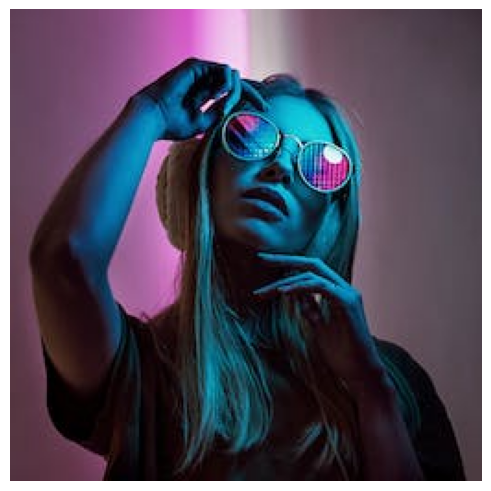

In [3]:
content_im = download_image(face_url).to(def_device)
print(content_im.shape)
show_image(content_im)

## Optimizing Images

In [4]:
class LengthDataset:
    def __init__(self, length=1):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return 0, 0


def get_dummy_dls(length=100):
    return DataLoaders(
        DataLoader(LengthDataset(length), batch_size=1),
        DataLoader(LengthDataset(length=1), batch_size=1),
    )

In [5]:
for b in get_dummy_dls(10).train:
    print(b)

[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]


In [6]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    
    def forward(self, x=0): return self.t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

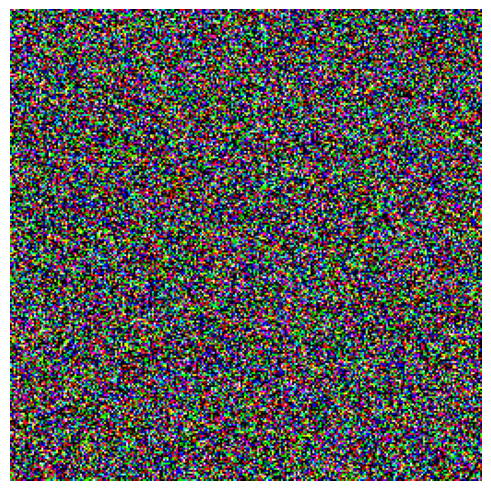

In [7]:
model = TensorModel(torch.randn_like(content_im))
show_image(model())

In [8]:
class ImageOptCB(AccelerateCB):
    def __init__(self):
        super().__init__(n_inp=0)

    def predict(self, learn):
        learn.preds = learn.model()

    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds)

crit=partial(F.mse_loss, target=content_im)

In [9]:
t = Trainer
t.default_cbs[1] = ImageOptCB()
learn = Trainer(model, get_dummy_dls(100), loss_func=crit)

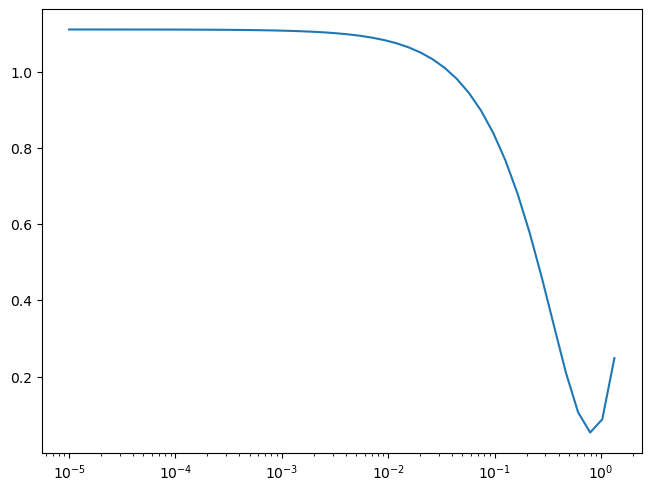

In [10]:
learn.lr_find()

epoch,train,loss
0,train,0.1140
0,eval,0.0000


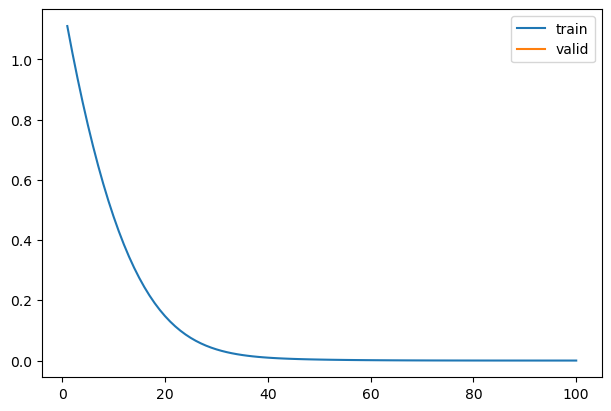

In [11]:
learn.fit(1, lr=1e-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


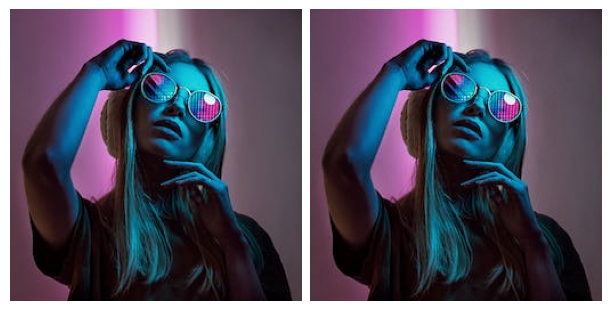

In [12]:
show_images([content_im, learn.model()])

## Log images as we go

In [13]:
class ImageLogCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10):
        self.log_every = log_every
        self.images = []
        self.i = 0
    
    def after_batch(self):
        if self.i % self.log_every == 0:
            self.images.append(to_cpu(learn.preds.clip(0,1)))
        self.i += 1
    
    def after_fit(self, learn):
        show_images(self.images)

